In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator, UnivariateSpline

In [2]:
DIRS = [Path("Data/pareto1"), Path("Data/pareto2")]
GLOB = "model_data_*.csv"

FILTER_UTILITY_POSITIVE = True
TOL = 1e-12
EPS_U_ABS = None
EPS_U_PCT = 0.02

OUT = Path("Figure/pareto_front")
OUT.mkdir(parents=True, exist_ok=True)
PARAM_KEYS = [
    "rewiring_p", "alpha", "rat", "risk",
    "normalizeGames", "dependence", "dependence_game"
]

param_patterns = {k: re.compile(rf"{k}_([\-\d\.]+)") for k in PARAM_KEYS}
rep_pat = re.compile(r"(?:^|_)rep(\d+)(?:\.csv$|_)")
seed_pat = re.compile(r"(?:^|_)seed(\d+)(?:\.csv$|_)")

def parse_params_from_name(name: str) -> dict:
    params = {}
    for k, pat in param_patterns.items():
        m = pat.search(name)
        if m is None:
            raise ValueError(f"Parameter '{k}' not found in filename: {name}")
        params[k] = float(m.group(1))
    rep = None
    seed = None
    m_rep = rep_pat.search(name)
    if m_rep is not None:
        rep = int(m_rep.group(1))
    m_seed = seed_pat.search(name)
    if m_seed is not None:
        seed = int(m_seed.group(1))
    params["rep"] = rep
    params["seed"] = seed
    return params

In [3]:
# Load runs
rows = []
for d in DIRS:
    if not d.is_dir():
        continue
    for f in d.glob(GLOB):
        df = pd.read_csv(f, usecols=["Gini Coefficient", "Total Social Utility"])  # last row only
        last = df.iloc[-1]
        gini = float(last["Gini Coefficient"])
        utility = float(last["Total Social Utility"])
        if FILTER_UTILITY_POSITIVE and not (utility > 0):
            continue
        info = parse_params_from_name(f.name)
        rows.append({
            "folder": d.name,
            "filename": f.name,
            "path": str(f),
            "gini": gini,
            "utility": utility,
            **info
        })

runs = pd.DataFrame(rows)
runs = runs.reset_index(drop=True)

In [4]:
# calculate Pareto front
sorted_idx = np.lexsort((-runs["utility"].to_numpy(), runs["gini"].to_numpy()))
sorted_runs = runs.iloc[sorted_idx].reset_index(drop=True)

util = sorted_runs["utility"].to_numpy()
prev_best = np.maximum.accumulate(np.r_[-np.inf, util[:-1]])  # best utility before i
is_front = util > (prev_best + TOL)

front = sorted_runs.loc[is_front].copy()

front = (front.sort_values(["gini", "utility"], ascending=[True, False])
               .drop_duplicates(subset=["gini"], keep="first")
               .sort_values("gini", ascending=True)
               .reset_index(drop=True))

front_cols = ["folder", "filename", "gini", "utility"] + PARAM_KEYS + ["rep", "seed", "path"]
front[front_cols].to_csv(OUT / "pareto_front_points.csv", index=False)

print(f"Pareto-front points: {len(front)}")

Pareto-front points: 14


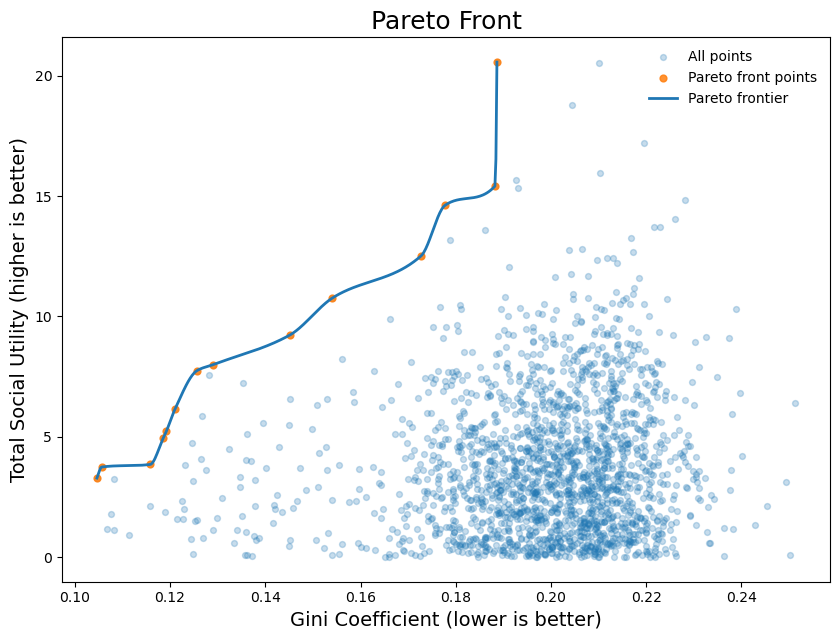

In [7]:
SMOOTH_MODE = "pchip"    # choose from {"pchip", "spline", "linear"}
NUM_POINTS = 400
SPLINE_S_FACTOR = None

x_front = front["gini"].to_numpy()
y_front = front["utility"].to_numpy()

x_grid = np.linspace(x_front.min(), x_front.max(), NUM_POINTS)

if SMOOTH_MODE == "pchip":
    interp = PchipInterpolator(x_front, y_front)
    y_smooth = interp(x_grid)

elif SMOOTH_MODE == "spline":
    if SPLINE_S_FACTOR is None:
        var = float(np.var(y_front)) if len(y_front) > 1 else 0.0
        s = 0.001 * len(x_front) * var
    else:
        s = float(SPLINE_S_FACTOR)
    spl = UnivariateSpline(x_front, y_front, s=s)
    y_smooth = spl(x_grid)

elif SMOOTH_MODE == "linear":
    A = np.vstack([x_front, np.ones_like(x_front)]).T
    b, a = np.linalg.lstsq(A, y_front, rcond=None)[0]
    y_smooth = a + b * x_grid
else:
    raise ValueError("Unknown SMOOTH_MODE")

plt.figure(figsize=(8.5, 6.5))
plt.scatter(runs["gini"], runs["utility"], alpha=0.25, s=18, label="All points")
plt.scatter(front["gini"], front["utility"], alpha=0.85, s=24, label="Pareto front points")
plt.plot(x_grid, y_smooth, linewidth=2.0, label=f"Pareto frontier")

plt.xlabel("Gini Coefficient (lower is better)", fontsize=14)
plt.ylabel("Total Social Utility (higher is better)", fontsize=14)
plt.title("Pareto Front", fontsize=18)
# plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(OUT / "pareto_front.png", dpi=150)